In [3]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib import rc
from matplotlib.ticker import AutoMinorLocator
import numpyro  

rc('font',**{'family':'serif','serif':['Times New Roman'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])

def default_axis(figsize = (6,4.5), 
               xlabel: str = None,
               ylabel: str = None,
               labelsize: int = 10,
               fontsize: int = 11,
               ax: plt.Axes = None,
               n_minor_ticks: int = 5):

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = None
    
    ax.set_xlabel(xlabel,fontsize = 10)
    ax.set_ylabel(ylabel,fontsize  = fontsize)
    ax.tick_params('both',labelsize = labelsize,direction = 'in',which = 'both')

    ax.xaxis.set_minor_locator(AutoMinorLocator(n_minor_ticks))
    ax.yaxis.set_minor_locator(AutoMinorLocator(n_minor_ticks))
    
    return fig,ax

c:\Users\mlanahan3\Anaconda3\envs\py312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### The Statistical Model

$X$ is the recrystillization fraction, $t$ the time and $T$ the temperature. The parameters of interest are the incubation time $t_n$, the exponent, $n$, and the rate coefficient $b$. $A_1,A_2,A_1,A_2$ are _nuisance_ parameters involved in the Arrhenius process description of the temperature dependence of $K$ and $t_{inc}$ on $T$. 

$
X = 1 - \exp{\left( -K (t - t_{inc})^n \right)} + \epsilon \\ 
b = A_1 \exp{\left(B_1/T \right)} \\ 
t_{inc} = A_2 \exp{\left(-B_2/T \right)} \\ 
$

### The data model is: 

$
X_{i} = 1 - \exp{\left( -K (t_{i} - t_{inc})^n \right)} + \epsilon_{i}\\ 
b = A_1 \exp{\left(-B_1/T_i \right)} \\ 
t_{inc} = A_2 \exp{\left(B_2/T_i \right)} \\ 
\epsilon_i/S \sim t_{n-1}  \quad \text{check this I'm not sure its right} \\  
$

Some contraints for the parameters;

$t_{inc} \geq 0, b > 0,B_1 > 0, B_2 > 0, A_1 > 0, A_2 > 0, n > 0$


### A simple model

let's begin with a simplified version, both to improve our intuition regarding the problem and also to make sure that a more complicated result is accurate. Consider:

$X = 1 - \exp{\left( -K (t - t_{inc})^n \right)} + \epsilon \\ 
X = f(t;b,n,t_{inc}) + \epsilon_i 
$

for one temperature so that $t$ is the only regressor.

$
X_i = 1 - \exp{\left( -K (t_i - t_{inc})^n \right)} + \epsilon_i \\ 
\epsilon_i \sim \mathcal{N}(0,\sigma^2)
$

where we have assumed identical error distribution. 

### Visualizing the Data

Showing the response of the recrstillization fraction to time at a specific temperature.

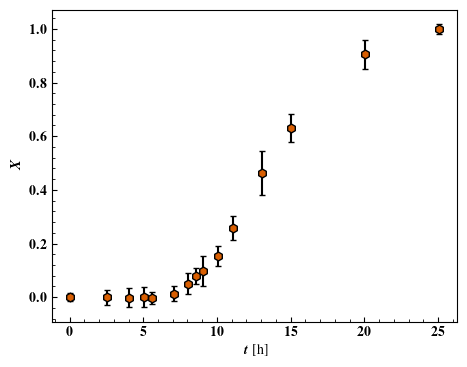

In [4]:
df = pd.read_csv('rf_data/alfonso_data/highly_rolled.csv',index_col = 0)

df = df.loc[df['temperature'] == 1200]
fig,ax = default_axis(figsize = (4.5,3.5),
                      xlabel = r'$t$ [h]',
                      ylabel = r'$X$')

ax.errorbar(df['time'],df['X'].to_numpy(),yerr = df['std'],fmt = 'none',ecolor = 'k',capsize = 2)
ax.scatter(df['time'],df['X'],facecolor  = plt.get_cmap('Dark2')(0.2),edgecolor = 'k',
           lw = 1.0,s = 40,marker = 'h',zorder = 1000)

fig.tight_layout(pad = 0.1)
fig.savefig('images/rolled_data_example_1200C.svg',dpi = 300)

### Point Estimation via Nonlinear Least Squares

We can use a nonlinear least squares method to estimate the parameters $(K,n, t_{inc})$. The problem is, we're not incorporating the  _uncertainty_ in our data, so points that saw significant spread during data influence the model just as points we are more sure about. We can rectify this using _weighted least squares_. As shown by the plot below, there isn't a significant change in the model prediction, but there is an enourmous change in the model _parameters_.

Unweighted Estimate
K: 3.0980054587833336e-05, n: 2.0499, t_inc: 6.0 [h]
Weighted Estimate
K: 2.8321329779323653e-05, n: 2.43, t_inc: 5.22 [h]


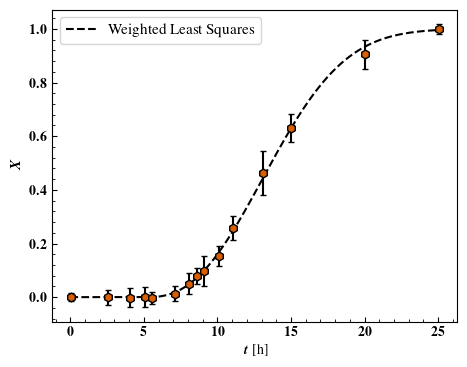

In [6]:
from scipy.optimize import differential_evolution
from scipy.stats.qmc import LatinHypercube
from typing import Callable, Tuple
from dataclasses import dataclass
import math

@dataclass
class ModelFunc:
    
    K: float
    n: float
    t_inc: float
    

    def __call__(self,t: np.ndarray):
        return self._func(t,self.K,self.n,self.t_inc)

    @staticmethod
    def _func(t: np.ndarray,K: float,n: float,t_inc: float):
        yhat = np.empty_like(t)
        index = t >= t_inc
        yhat[~index] = 0
        yhat[index] = 1.0 - np.exp(-K**n*(t[index]-t_inc)**n)
        return yhat

    @classmethod
    def fit(cls,t: np.ndarray,X: np.ndarray,
                opt_method: Callable,
                bounds: Tuple[np.ndarray],
                weights: np.ndarray = None,
                **kwargs):
        
        w = np.ones_like(t) if not isinstance(weights,np.ndarray) and weights is None else weights
        bounds[0] = np.log(bounds[0])
        def resid_ss(theta: np.ndarray):
            theta[0] = math.exp(theta[0])
            return np.sum((w*(X - cls._func(t,*theta)))**2)
        
        opt_res = opt_method(resid_ss,bounds,**kwargs)
        if opt_res.success:
            x = opt_res.x.copy()

            x[0] = np.exp(x[0])
            return cls(*x)
        else:
            raise ValueError(f'Optimization failed: {opt_res.message}')
        
        
    
df = pd.read_csv('rf_data/alfonso_data/highly_rolled.csv',index_col = 0)
df = df.loc[df['temperature'] == 1200]
df['time']*=3600
x = df['time'].to_numpy()
y = df['X'].to_numpy()
y[y <= 0 ] = 0.0
y[y >= 1] = 1
w = 1/df['std'].to_numpy()**2

bounds = np.array([[1e-20,0.0,0],[1,3.0,x.max()/2]]).T
model = ModelFunc.fit(x,y,differential_evolution,bounds.copy(),maxiter = 10000,tol = 1e-10)
model_weighted = ModelFunc.fit(x,y,differential_evolution,bounds.copy(),
                               weights = w,maxiter = 10000,tol = 1e-10)

print('Unweighted Estimate')
print(f'K: {model.K}, n: {round(model.n,4)}, t_inc: {round(model.t_inc/3600,0)} [h]')

print('Weighted Estimate')
print(f'K: {model_weighted.K}, n: {round(model_weighted.n,2)}, t_inc: {round(model_weighted.t_inc/3600,2)} [h]')

df = pd.read_csv('rf_data/alfonso_data/highly_rolled.csv',index_col = 0)

df = df.loc[df['temperature'] == 1200]
fig,ax = default_axis(figsize = (4.5,3.5),
                      xlabel = r'$t$ [h]',
                      ylabel = r'$X$')

ax.errorbar(df['time'],df['X'].to_numpy(),yerr = df['std'],fmt = 'none',ecolor = 'k',capsize = 2)
ax.scatter(df['time'],df['X'],facecolor  = plt.get_cmap('Dark2')(0.2),edgecolor = 'k',
           lw = 1.0,s = 40,marker = 'h',zorder = 1000)

t = np.linspace(0,x.max(),1000)
#ax.plot(t/3600,model(t),color = 'k',lw = 1.5,label = 'Ordinary Least Squares')
ax.plot(t/3600,model_weighted(t),color = 'k',lw = 1.5,label = 'Weighted Least Squares',ls = '--')
ax.legend(fontsize = 11)
fig.tight_layout(pad = 0.1)
fig.savefig('images/rolled_data_example_1200C_wls_fit.svg',dpi = 300)


### Interval Estimation

The primary issue with the least square approach here is that we don't have any confidence intervals on our parameter estimates. As we see in the difference between the point estimates for the ordinary and weighted least squares estimates, they can vary substantially while still predicting effectively the same model response. Unfortunatley, no closed form solution exists for these distributions. 

We can, however, use the bayesian approach, using the gaussian likelihood implied by the above model:

$
p(K,n,t_{inc} | \mathbf{t}, \mathbf{X}) \propto \mathcal{L}(\mathbf{t}, \mathbf{X}| K,n,t_{inc})p(K,n,t_{inc}) \\ 
\mathcal{L}(\mathbf{t}, \mathbf{X}| K,n,t_{inc}) = \frac{1}{(2\pi)^{n/2} |\mathbf{\Sigma}|} \exp{\left(-\frac{1}{2}(\left(\mathbf{X} - f(\mathbf{t};K,n,t_{inc})\right)^T \mathbf{\Sigma}^{-1} \left(\mathbf{X} - f(t;K,n,t_{inc}\right)\right)}
$

This leaves us with having to specify the prior $p(K,n,t_{inc})$. We see from the least squares above that $K << 1$, and further that $t_{inc} < \text{max}_i{t_i}$ and from the literature we can determine that $0 < n \leq 5$. Finally, the parameters should be positive, and further assuming independence:

$
p(K,n,t_{inc}) = p(K)p(n)p(t_{inc}) \\ 
p(K) \sim \mathcal{U}((0,1]) \qquad p(n) \sim \mathcal{U}([0,5]) \qquad p(t_{inc}) \sim \mathcal{U}([0,\text{max}_i{t_i}])
$

In [37]:
from jax import random, vmap
import jax
import jax.numpy as jnp
from numpyro.distributions import MultivariateNormal, Normal
from numpyro.infer import init_to_value

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

def kernel(X: jnp.ndarray, 
           Z: jnp.ndarray, 
           sigma: float, 
           length: jnp.ndarray,
           noise: jnp.ndarray = None, 
           include_noise=True,
           jitter: float = 1e-4):
    
    deltaXsq = jnp.power((X[..., jnp.newaxis] - Z) / length, 2.0)
    k = sigma**2 * jnp.exp(-0.5 * deltaXsq)
    if include_noise:
        k = jnp.fill_diagonal(k,k.ravel()[::k.shape[0] + 1] + (noise + jitter),inplace = False)
    
    return k


def model_func(t: np.ndarray,K: float,n: float,t_inc: float):        
        return 1.0 - jnp.exp(-K**n*(jnp.where(t > t_inc, t,t_inc) - t_inc)**n)

def bayesian_gp_model(t: jnp.ndarray = None,
                      X: jnp.ndarray = None,
                      noise: jnp.ndarray= None):
    
    if t is None:
         raise ValueError('t must be provided')

    K = numpyro.sample('K',numpyro.distributions.Uniform(1e-5,1e-2))
    n = numpyro.sample('n',numpyro.distributions.Uniform(1,4.5))
    t_inc = numpyro.sample('t_inc',numpyro.distributions.Uniform(0,t.max()/2))
    sigma = numpyro.sample('sigma',numpyro.distributions.Exponential(10.0))
    l1 = numpyro.sample('l1',numpyro.distributions.Uniform(t.max()/10,t.max()*10))

    Kernel = kernel(t,t,sigma,l1,noise,include_noise = isinstance(noise,jnp.ndarray))
    
    X_hat = model_func(t,K,n,t_inc)
    numpyro.sample('obs',MultivariateNormal(loc = X_hat, covariance_matrix= Kernel),obs = X)
    

df = pd.read_csv('rf_data/alfonso_data/highly_rolled.csv',index_col = 0)
df = df.loc[df['temperature'] == 1200]
df['time']*=3600
x = df['time'].to_numpy()
y = df['X'].to_numpy()
y[y <= 0 ] = 0.0
y[y >= 1] = 1
noise = df['std'].to_numpy()**2

bounds = np.array([[1e-20,0.0,0],[1,3.0,x.max()/2]]).T
model = ModelFunc.fit(x,y,differential_evolution,bounds.copy(),maxiter = 10000,tol = 1e-10)
model_weighted = ModelFunc.fit(x,y,differential_evolution,bounds.copy(),
                               weights = w,maxiter = 10000,tol = 1e-10)

resid = model_weighted(x) - y
rss = np.sum(w*resid**2)
sigma = np.sqrt(rss/(len(t) - 3))
init_params = {'K':model_weighted.K,'n':model_weighted.n, 't_inc':model_weighted.t_inc,'sigma':sigma,'l1':x.mean()/2}
nuts_kernel = numpyro.infer.NUTS(bayesian_gp_model)

mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_samples=3000,
    num_warmup=500,
    num_chains= 1,
)

mcmc.run(rng_key_,jnp.array(x),jnp.array(y),noise = jnp.array(noise),
         init_params = init_params)
mcmc.print_summary()
posterior_samples = mcmc.get_samples()


sample: 100%|██████████| 3500/3500 [00:17<00:00, 202.48it/s, 31 steps of size 6.42e-02. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         K      0.00      0.00      0.00      0.00      0.00    845.97      1.00
        l1 470776.06 250401.16 474790.25 117739.16 893911.25   1863.17      1.00
         n      2.70      0.75      2.62      1.57      3.97    679.12      1.00
     sigma      0.03      0.04      0.02      0.00      0.08   1213.16      1.00
     t_inc  16374.28   7159.10  17065.94   4247.23  27255.83    724.50      1.00

Number of divergences: 0


### Visualization of Parameter Posteriors

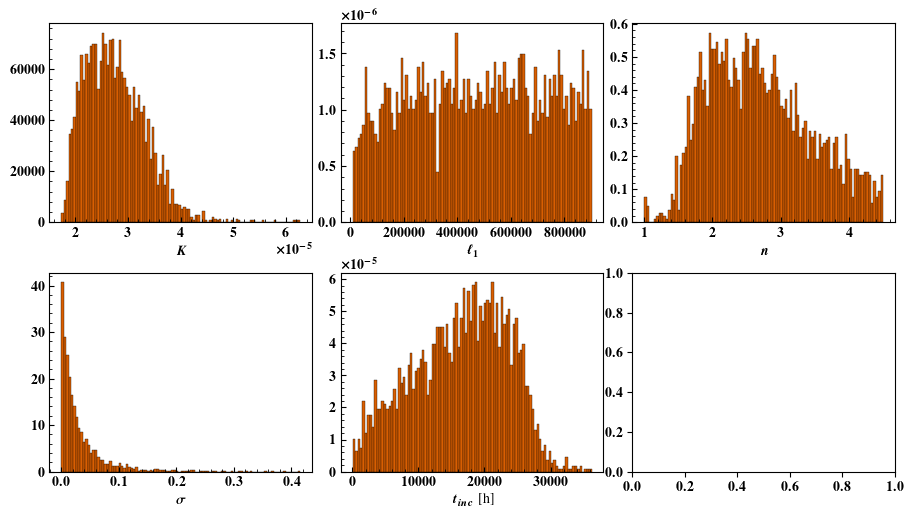

In [38]:
fig,axes = plt.subplots(figsize = (9,5),nrows = 2,ncols = 3)
xlabels = {'K':r'$K$','n':r'$n$','t_inc':r'$t_{inc}$ [h]','sigma': r'$\sigma$','l1': r'$\ell_1$'}
for ax,key in zip(np.ravel(axes),posterior_samples.keys()):
    _,ax = default_axis(ax = ax,xlabel= xlabels[key])
    ax.hist(np.array(posterior_samples[key]),bins = 100,edgecolor = 'k',color = plt.get_cmap('Dark2')(0.2),density = True,lw = 0.25)

fig.tight_layout(pad = 0.1)


### Visualization of Predictive Posteriors

The predictive distribution is:

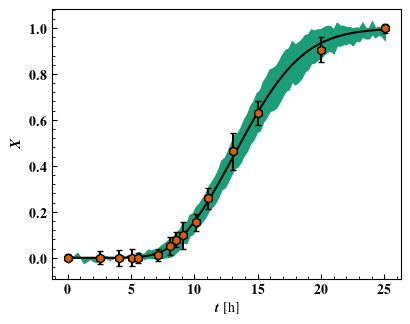

In [39]:
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

    
def sample_posterior_predictive(t: jnp.ndarray,
                                X: jnp.ndarray,
                                tnew: jnp.ndarray,
                                K: float,
                                n: float,
                                t_inc: float,
                                sigma: float,
                                length: float,
                                noise: jnp.ndarray):
     
    k_new = kernel(tnew,tnew,sigma,length,include_noise = False)
    k_pX = kernel(tnew,t,sigma,length,include_noise = False)
    k_XX = kernel(t,t,sigma,length,noise = noise,include_noise = True)
    K_xx_inv = jnp.linalg.inv(k_XX)
    Kernel = k_new - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
    mean_offset = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, X))
    mean_eval = model_func(tnew,K,n,t_inc)
    mean = mean_eval
    return mean,mean + jnp.sqrt(jnp.clip(jnp.diag(Kernel), 0.0)) * jax.random.normal(
        rng_key, tnew.shape[:1]
    )


vmap_args  = (posterior_samples[key] for key in ['t_inc','K','n','sigma','l1'])

t_predict = np.linspace(0,t.max(),100)
predictive_means,predictive_samples = vmap(
    lambda t_inc,K,n,sig,l1: sample_posterior_predictive(jnp.array(x),jnp.array(y),t_predict,K,n,t_inc,sig,l1,jnp.array(noise)),
)( *vmap_args)


mean_response = np.mean(predictive_means,axis = 0)
hpdi_posterior = hpdi(predictive_samples,0.95)

fig,ax = default_axis(figsize = (4.5,3.5),
                        xlabel = r'$t$ [h]',
                        ylabel = r'$X$')


ax.fill_between(t_predict/3600, hpdi_posterior[0, :], hpdi_posterior[1, :], color=plt.get_cmap('Dark2')(0.1))
ax.plot(t_predict/3600,mean_response,color = 'k',lw = 1.5,label = 'Mean Response')
ax.errorbar(df['time']/3600,df['X'].to_numpy(),yerr = df['std'],fmt = 'none',ecolor = 'k',capsize = 2)
ax.scatter(df['time']/3600,df['X'],facecolor  = plt.get_cmap('Dark2')(0.2),edgecolor = 'k',
           lw = 1.0,s = 40,marker = 'h',zorder = 1000)